In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.models import resnet18
from torchvision import transforms
from tqdm import tqdm
from torch import nn
from torch.utils.data import Dataset,TensorDataset,DataLoader,random_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from d2l import torch as d2l
import random
import os
import torch.nn.functional as F
from torch.autograd import grad
import torch.nn.init as init
d2l.use_svg_display()


## 加载原始数据

3.976819030129083
3.9749632510379773
3.9771887805331407
3.9772694580660666


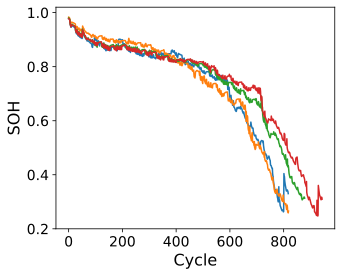

In [2]:
def smooth_data(sequence, window_size):
    """数据平滑"""
    if window_size < 1:
        raise ValueError("窗口大小必须大于等于1")
    # 初始化平滑后的数据列表
    smoothed_sequence = []
    # 计算窗口内的平均值
    for i in range(len(sequence)):
        # 计算窗口的起始和结束索引
        start_index = max(0, i - window_size + 1)
        end_index = i + 1
        # 计算窗口内的数据平均值
        window_average = sum(sequence[start_index:end_index]) / (end_index - start_index)
        # 将平均值添加到平滑后的数据列表中
        smoothed_sequence.append(window_average)
    return smoothed_sequence
def add_row_index_to_array(arr):
    """
    在输入数组的每一行的第一个元素加上行号，并扩展数组维度。
    
    参数:
    arr (np.ndarray): 形状为 (n, 6) 的输入数组。
    
    返回:
    np.ndarray: 形状为 (n, 7) 的数组。
    """
    # 检查输入数组形状是否为 (n, 6)
    if arr.shape[1] != 10:
        raise ValueError("输入数组必须是形状为 (n, 10) 的数组。")

    # 创建一个新数组，其形状为 (n, 7)，初始化为输入数组
    new_arr = np.zeros((arr.shape[0], 11))
    new_arr[:, 1:] = arr  # 将输入数组的数据复制到新数组的后面六个列
    # 在新数组的每一行的第一个元素加上行号
    new_arr[:, 0] = np.arange(arr.shape[0])
    return new_arr
def drop_outlier(array,count,bins):
    """离群值提取--用3sigma方法"""
    index = []
    range_n = np.arange(1,count,bins)
    for i in range_n[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)
def clean_data(array_figs,array_labels):
    index_keep=drop_outlier(array_labels,len(array_labels),35)
    array_figs,array_labels=array_figs[index_keep],array_labels[index_keep]
    array_figs,array_labels=array_figs[drop_outlier(array_labels,len(array_labels),10)],array_labels[drop_outlier(array_labels,len(array_labels),10)]
    return array_figs,array_labels
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
data_root='../data/CACLE_data/all_path/'
plt.figure(figsize=(5, 4))
for name in Battery_list:
    path=data_root+name+'.npz'
    arrays=np.load(path)
    features,SOHs=clean_data(arrays['array1'],arrays['array2'])
    plt.plot(SOHs)
    # """抛弃异常值处理"""
    # index_keep=drop_outlier(SOHs,len(SOHs),35)
    # plt.plot(SOHs[index_keep][drop_outlier(SOHs[index_keep],len(SOHs[index_keep]),10)])
    # plt.plot(process_sequence(SOHs,1))
    plt.yticks([0.2,0.4,0.6,0.8,1],fontsize=14)
    plt.xticks(fontsize=14)
    plt.xlabel('Cycle', fontsize=16)
    plt.ylabel('SOH',fontsize=16)
    print(features[1][0])
plt.show()

# 数据的读取和设置函数

In [3]:
def setup_seed(seed):
    """set random seed"""
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse
def get_data():
    """获取训练集，测试集，验证集"""
    train_list = Battery_list
    train_data=[]
    for b_n in train_list:
        path = '../data/CACLE_data/all_path/' + b_n + '.npz'
        arrays = np.load(path)
        a,b=clean_data(arrays['array1'],arrays['array2'])
        a=add_row_index_to_array(a)
        train_data.append([a,b])
    train_valid_features=torch.from_numpy(train_data[0][0]).float()
    train_valid_labels=torch.from_numpy(train_data[0][1]).float()
    dataset=TensorDataset(train_valid_features,train_valid_labels)
    # 确定训练集和验证集的大小
    train_size = int(1*0.8 * len(dataset))  # 80%的训练集
    val_size = len(dataset) - train_size   # 剩余的20%作为验证集
    # 随机分割数据集
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    # 创建DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_35_data,test_36_data,test_37_data=[train_data[1][0],train_data[1][1]],[train_data[2][0],train_data[2][1]],[train_data[3][0],train_data[3][1]]
    return train_loader, val_loader, test_35_data, test_36_data, test_37_data

a,b,_,_,_=get_data()
for x,y in b:
    print(x.shape)

torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([32, 11])
torch.Size([4, 11])


## 定义模型

In [4]:
def calculate_model_size(model):
    """
    计算深度学习模型的大小。
    
    参数:
    model -- PyTorch模型
    
    返回:
    model_size -- 模型大小，以兆字节(MB)为单位
    """
    # 初始化参数大小的计数
    total_params = 0
    
    # 遍历模型中的所有参数
    for param in model.parameters():
        # 计算参数的数量
        num_params = param.numel()
        total_params += num_params
    
    # 假设参数以32位浮点数存储
    bits_per_param = 32
    bytes_per_param = bits_per_param / 8
    
    # 计算总字节数
    total_bytes = total_params * bytes_per_param
    
    # 转换为兆字节
    model_size_mb = total_bytes / (1024**2)
    
    return model_size_mb

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0):
        """用多头注意力进行解码"""
        """
        多头注意力模块。
        :param input_dim: 输入特征维度
        :param output_dim: 输出特征维度
        :param num_heads: 注意力头的数量
        :param head_dim: 每个注意力头的维度
        :param dropout: Dropout 概率
        """
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim-1
        self.output_dim = output_dim-1
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.dropout = dropout
        # 线性变换层，将输入映射到 Q, K, V
        self.query = nn.Linear(input_dim-1, num_heads * head_dim)
        self.key = nn.Linear(input_dim-1, num_heads * head_dim)
        self.value = nn.Linear(input_dim-1, num_heads * head_dim)
        # 输出线性层
        self.fc_out = nn.Linear(num_heads * head_dim, output_dim-1)
        # Dropout 层
        self.dropout_layer = nn.Dropout(dropout)
    def forward(self, x):
        """
        前向传播。
        :param x: 输入张量，形状为 (batch_size, input_dim)
        :return: 输出张量，形状为 (batch_size, output_dim)
        """
        batch_size = x.size(0)
        x_t=x[:,0].unsqueeze(1)
        x=x[:,1:]
        # 线性变换，得到 Q, K, V
        Q = self.query(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        K = self.key(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)    # (batch_size, num_heads, seq_len, head_dim)
        V = self.value(x).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        # 计算注意力分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = self.dropout_layer(attention_weights)
        # 计算加权和
        attention_output = torch.matmul(attention_weights, V)  # (batch_size, num_heads, seq_len, head_dim)
        # 拼接多头输出
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.head_dim)  # (batch_size, seq_len, num_heads * head_dim)
        # 通过线性层映射到输出维度
        output = self.fc_out(attention_output)  # (batch_size, seq_len, output_dim)
        output=torch.cat((x_t,output.squeeze(1)),dim=-1)
        return output  # (batch_size, output_dim)
"""--------------------------------------------------------多物理场混合专家模型-------------------------------------------------------"""
class MixtureOfExperts(nn.Module):
    def __init__(self, input_dim, num_experts, expert_hidden_dim):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        # 专家网络
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, 2*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(2*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,64*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(64*expert_hidden_dim,32*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(32*expert_hidden_dim,16*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(16*expert_hidden_dim, 8*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(8*expert_hidden_dim, 4*expert_hidden_dim),
                nn.ReLU(),
                nn.Linear(4*expert_hidden_dim,expert_hidden_dim ),
            )
            for _ in range(num_experts)
        ])
        # 门控网络
        self.gating_network = nn.Linear(input_dim, num_experts)
        # 输出层
        self.output_layer = nn.Linear(expert_hidden_dim, 1)
    def initialize_weights(self):
        nn.init.xavier_uniform_(self.gating_network.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)
    def forward(self, x):
        # 计算所有专家的输出
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        #shape(batch_size,num_expert,expert_hidden_dim)
        # 计算门控网络的输出并应用softmax得到权重
        gate_works=torch.exp(self.gating_network(x)/500)
        gating_outputs = F.softmax(gate_works, dim=1)
        # 将门控网络的输出（权重）与专家网络的输出相乘并求和
        combined_output = torch.sum(expert_outputs * gating_outputs.unsqueeze(-1), dim=1)
        # 通过输出层得到最终输出
        final_output = self.output_layer(combined_output)
        return final_output,expert_outputs      #返回总输出和每个专家输出
    
class PINN_MOE(nn.Module):
    def __init__(self,input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0,expert_input_dim=12, num_experts=3,expert_hidden_dim=2):
        super(PINN_MOE, self).__init__()
        self.Decoupling=MultiHeadAttention(input_dim, output_dim, num_heads, head_dim, dropout)
        self.multi_physics=MixtureOfExperts(expert_input_dim, num_experts,expert_hidden_dim)
        self.physics=nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        # self.electricity=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.heat=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        # self.mechine=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        self.parameter_heat=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity1=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity2=nn.Parameter(torch.tensor(1, dtype=torch.float32))
    def  initialize_weights(self):
        nn.init.xavier_uniform_(self.Decoupling.parameters)
        nn.init.xavier_uniform_(self.multi_physics.parameters)
        # nn.init.xavier_uniform_(self.heat.parameters)
        # nn.init.xavier_uniform_(self.mechine.parameters)
        # nn.init.xavier_uniform_(self.electricity.parameters)
        nn.init.xavier_uniform_(self.physics.parameters)
        nn.init.xavier_uniform_(self.parameter_heat)
        nn.init.xavier_uniform_(self.parameter_electricity1)
        nn.init.xavier_uniform_(self.parameter_electricity2)
    def forward(self, tx):
        tx.requires_grad_(True)
        # 解耦输入
        t_x = self.Decoupling(tx)
        t=t_x[:,0:1]
        x=t_x[:,1:]
        # 预测物理量
        s_pred,experts = self.multi_physics(torch.cat((t,x),dim=1))
        # 计算 s_pred 对 t 和 x 的偏导数
        """综合损失"""
        s_t = grad(s_pred.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        s_x = grad(s_pred.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        """热效应损失"""
        T_Q=experts[:,0:1,:].squeeze(1)
        # print(T_Q.shape)
        T=T_Q[:,0:1]
        Q=T_Q[:,1:2]
        T_t=grad(T.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_x=grad(T.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_laplace=grad(T_t.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_heat=torch.mean((T_t - (self.parameter_heat) * T_laplace - Q) ** 2, dim=1).unsqueeze(1)
        """电化学效应损失"""
        phi_c=experts[:,1:2,:].squeeze(1)
        phi=phi_c[:,0:1]
        c=phi_c[:,1:2]
        phi_t=grad(phi.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_x=grad(phi.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_x=grad(c.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_t=grad(c.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_laplace=grad(phi_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_laplace=grad(c_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_electricity=torch.mean((c_t -self.parameter_electricity1 * c_laplace -self.parameter_electricity2) ** 2,dim=1).unsqueeze(1)+torch.mean(phi_laplace** 2,dim=1).unsqueeze(1)
        """机械应力损失"""
        sigma_f=experts[:,2:3,:].squeeze(1)
        sigma=sigma_f[:,0:1]
        f=sigma_f[:,1:2]
        sigma_x=grad(sigma.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        sigma_laplace=grad(sigma_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_mechine=torch.mean((sigma_laplace + f) ** 2,dim=1).unsqueeze(1)
        # 打印 s_t 和 s_x，确保它们不为 None
        # 计算物理约束 F
        F_input = torch.cat([phi,c,T,Q,sigma,f], dim=1)
        soh = self.physics(F_input)
        # 计算残差 f
        loss_all = 1*loss_electricity+1*loss_heat+1*loss_mechine
        return soh, loss_all,[phi,c,T,Q,sigma,f]
        

In [6]:
test_model=PINN_MOE()
calculate_model_size(test_model)

0.2736625671386719

## 用于训练的函数

In [7]:
def train(lr=0.003,epochs=200, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = PINN_MOE()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    lists=[]
    train_loss=10
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred,f,_= model(X)
            f_target = torch.zeros_like(f)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)+0.3*criterion(f,f_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
            train_loss=loss_epoch/len_dataloader
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre,_,_=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<3e-5 and epoch>30)or (epoch+1)==epochs:
            model=model.cpu()
            torch.save(model.state_dict(), '../pretrained/cacle_model.pth')
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred,_,list=model(X)
                for i in range(len(list)):
                    list[i]=list[i].detach().cpu().numpy()
                lists.append(list)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results,lists
        

## 五个随机种子训练

In [8]:
tests=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result,_=train(seed=i,device=device)
    tests.append(test_result)


training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0997, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(9.1746e-05, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0357, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0002, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0220, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0023, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(8.1489e-05, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0049, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(4.6418e-05, device='cuda:0') 



KeyboardInterrupt: 

## 误差计算—————RMSE和MAE—————一共5个随机种子进行训练取平均值————————需要运行请将注释取消

## MAE代码

In [9]:
def calculate_mae(actual, predicted):
    """
    计算两个序列的MAE（平均绝对误差）
    
    参数:
    actual (list or numpy array): 实际值序列
    predicted (list or numpy array): 预测值序列
    
    返回:
    float: MAE值
    """
    # 确保输入序列长度一致
    if len(actual) != len(predicted):
        raise ValueError("实际值序列和预测值序列长度必须一致")
    
    # 计算绝对误差
    absolute_errors = [abs(a - p) for a, p in zip(actual, predicted)]
    
    # 计算平均绝对误差
    mae = sum(absolute_errors) / len(actual)
    
    return mae
def mape(sequence_true, sequence_pred):
    """
    计算两个序列的MAPE（Mean Absolute Percentage Error）

    参数:
    sequence_true: 实际值序列
    sequence_pred: 预测值序列

    返回:
    mape: 平均绝对百分比误差
    """
    if len(sequence_true) != len(sequence_pred):
        raise ValueError("两个序列的长度必须相同")

    # 计算绝对百分比误差
    ape = [abs((true - pred) / true) for true, pred in zip(sequence_true, sequence_pred) if true != 0]

    # 计算平均绝对百分比误差
    mape = sum(ape) / len(ape)

    return mape

# 示例使用
sequence_true = [100, 200, 300, 400, 500]
sequence_pred = [90, 210, 310, 380, 480]
# print("MAPE:", mape(sequence_true, sequence_pred))
def r_squared(y_true, y_pred):
    """
    计算两个序列的R方（R-squared）

    参数:
    y_true: 实际值序列
    y_pred: 预测值序列

    返回:
    r2: R方值
    """
    # 计算实际值的平均值
    y_mean = sum(y_true) / len(y_true)
    
    # 计算总平方和（Total Sum of Squares, TSS）
    ss_total = sum((y_true - y_mean) ** 2)
    
    # 计算回归平方和（Regression Sum of Squares, RSS）
    ss_residual = sum((y_true - y_pred) ** 2)
    
    # 计算R方
    r2 = 1 - (ss_residual / ss_total)
    
    return r2




## 衡量损失

In [50]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
test_csv_p=[]
real_csv_p=[]
for i in range(4):
    for j in range(len(tests[0])):
        real,pred=tests[i][j][0],tests[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        if rmse>=0.00:
            rmse_all.append(rmse)
            for pre,rea in zip(pred,real):
                test_csv_p.append(pre)
                real_csv_p.append(rea)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("test:",test_csv_p)
print('real:',real_csv_p)
len(test_csv_p)
# print("MAE:",mae_all)
# print("MAPE:",mape_all)
# print("R2:",r2)

RMSE: [0.004857104572893562, 0.004332116468396408, 0.006259236139168744, 0.009031370544399855, 0.005325168321145606, 0.009619786357144557, 0.005441400473301335, 0.0037400875048313664, 0.0071854630097592746, 0.006666025802587155, 0.006250479583345898, 0.011879050883576738]
test: [0.9776682, 0.9770874, 0.9767492, 0.9780219, 0.977257, 0.9696647, 0.96435946, 0.96206576, 0.9598791, 0.9589362, 0.96400297, 0.96525013, 0.96537113, 0.9654183, 0.96538013, 0.96538067, 0.9651019, 0.96475613, 0.96434283, 0.9639669, 0.96355104, 0.96327287, 0.9630682, 0.96261805, 0.9619562, 0.95877165, 0.950485, 0.9475844, 0.9457108, 0.9436035, 0.9457898, 0.95166874, 0.94933164, 0.94212925, 0.9395139, 0.9392275, 0.93781674, 0.9416485, 0.9463389, 0.9435688, 0.9362815, 0.93562376, 0.9351389, 0.93366754, 0.9363637, 0.9418565, 0.9400375, 0.93376136, 0.93297076, 0.9321802, 0.9303224, 0.93086696, 0.9494091, 0.9473082, 0.94271654, 0.9401781, 0.9409053, 0.937427, 0.9335034, 0.9327747, 0.9314166, 0.9294305, 0.9285295, 0.92953

10568

## 挑出来一组用于画图

In [11]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# test_results,lists=train(seed=1,device=device)

# 保存结果用于画图

In [12]:
# reals=[]
# preds=[]
# for i in range(3):
#     real,pred=test_results[i][0],test_results[i][1]
#     reals.append(real)
#     preds.append(pred)
# reals=np.concatenate(reals,axis=0)
# preds=np.concatenate(preds,axis=0).squeeze()
# path='D:/Pywork/CNN_ATTENTION_PINN/new/results/preds/cacle.npz'
# np.savez(path,reals=reals,preds=preds)

In [13]:
# plt.plot(reals,preds)

In [14]:
# for i in range(3):
#     real,pred=test_results[i][0],test_results[i][1]
#     rmse=evaluation(real,pred)
#     print(rmse)

In [15]:
# from matplotlib.ticker import MaxNLocator
# # from matplotlib.ticker import MinNLocator
# import matplotlib.pyplot as plt
# import numpy as np
# # 示例数据
# true_soh=np.concatenate((test_results[0][0],test_results[1][0],test_results[2][0]),axis=0)
# # true_soh = test_results[1][0]
# prediction=np.concatenate((test_results[0][1].reshape(-1),test_results[1][1].reshape(-1),test_results[2][1].reshape(-1)),axis=0)
# def filter_arrays(arr1, arr2, threshold=0.8):
#     """
#     删除第一个数组中小于阈值的部分，并根据第一个数组删除的索引，删除第二个数组的对应值。
# 
#     参数:
#     arr1 (np.array): 第一个数组。
#     arr2 (np.array): 第二个数组。
#     threshold (float): 阈值，默认为0.8。
# 
#     返回:
#     filtered_arr1 (np.array): 过滤后的第一个数组。
#     filtered_arr2 (np.array): 过滤后的第二个数组。
#     """
#     # 检查两个数组长度是否相同
#     if len(arr1) != len(arr2):
#         raise ValueError("两个数组的长度必须相同！")
# 
#     # 找到第一个数组中大于等于阈值的索引
#     valid_indices = arr1 >= threshold
# 
#     # 根据索引过滤两个数组
#     filtered_arr1 = arr1[valid_indices]
#     filtered_arr2 = arr2[valid_indices]
# 
#     return filtered_arr1, filtered_arr2
# true_soh,prediction=filter_arrays(true_soh,prediction)
# # print(true_soh)
# # print(prediction.reshape(-1))
# distance = np.abs(true_soh - prediction) / np.sqrt(2)
# # print(distance)
# # 创建散点图
# plt.figure(figsize=(8, 7))
# scatter = plt.scatter(true_soh, prediction, c=distance, cmap='Blues_r', alpha=1,s=30)
# 
# # 添加中间红线
# plt.plot([0.80, 1.00], [0.80, 1.00], color='red', linestyle='--')
# plt.xticks(np.arange(0.80, 1.01, 0.05),fontsize=25)
# plt.yticks(np.arange(0.80, 1.01, 0.05),fontsize=25)
# # 添加颜色条
# cbar = plt.colorbar(scatter)
# cbar.set_label('Absolute error',fontsize=25)
# cbar.ax.tick_params(labelsize=24)
# # 设置最大刻度数为5
# cbar.locator = MaxNLocator(nbins=5)
# # 实际显示刻度数 = nbins + 1
# cbar.update_ticks()
# # 将刻度线画在坐标轴内部
# plt.tick_params(axis='both', direction='in')
# 
# # 添加标签和标题
# plt.xlabel('True SOH',fontsize=30)
# plt.ylabel('Prediction',fontsize=30)
# plt.title('CACLE dataset',fontsize=30)
# # plt.legend()
# 
# # 显示图表
# plt.show()

## MLP

In [22]:
class MLP(nn.Module):
    def __init__(self, input_size=11, output_size=1):
        super(MLP, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_size, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, output_size))
    def forward(self, x):
        return self.net(x)
def train_mlp(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = MLP()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<4e-5 and epoch>=35)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [23]:
test_model=MLP()
calculate_model_size(test_model)

0.3244667053222656

## 随机种子训练

In [24]:
tests_mlp=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_mlp(seed=i,device=device)
    tests_mlp.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(9.8307e-05, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(7.0936e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(6.4290e-05, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(3.9630e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(2.7710e-05, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(2.0902e-05, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(3.0313e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0002, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(2.4381e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(5.9930e-05, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0001, device='cuda:0', grad_fn=<DivBackward0>) 



In [51]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
test_csv_m=[]
real_csv_m=[]
for i in range(4):
    for j in range(len(tests[0])):
        real,pred=tests_mlp[i][j][0],tests_mlp[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        if rmse>=0.00:
            rmse_all.append(rmse)
            for pre,rea in zip(pred,real):
                test_csv_m.append(pre)
                real_csv_m.append(rea)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("test:",test_csv_m)
print('real:',real_csv_m)
len(test_csv_m)

RMSE: [0.009594816270972485, 0.01629495091807566, 0.012124559697155365, 0.005060032498500981, 0.010594182297185402, 0.012204089901211582, 0.005833102360464565, 0.00965190898038107, 0.006381496914042974, 0.006133324827227252, 0.0074203549964946295, 0.006112910706840008]
test: [0.9797869, 0.978881, 0.9786216, 0.9732443, 0.9712995, 0.969869, 0.9634999, 0.96123064, 0.9584142, 0.95531356, 0.95745504, 0.95571685, 0.9546424, 0.95363176, 0.9526118, 0.9510361, 0.950359, 0.949937, 0.9489368, 0.9480382, 0.94725585, 0.9464625, 0.94598794, 0.94503987, 0.9441966, 0.94800305, 0.9441546, 0.9408456, 0.93945336, 0.93773687, 0.93465114, 0.93792295, 0.9414327, 0.93517125, 0.93287504, 0.9322301, 0.93143535, 0.9312155, 0.9341675, 0.935833, 0.9289702, 0.92768395, 0.9276463, 0.92691207, 0.9258913, 0.930179, 0.93124163, 0.9260869, 0.92492867, 0.9238422, 0.92298245, 0.9216285, 0.94305325, 0.94076276, 0.939173, 0.93329823, 0.9345943, 0.9317733, 0.9277017, 0.92670894, 0.9249717, 0.9234787, 0.92228544, 0.9231992, 

10568

## 误差计算

In [119]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests_mlp)):
#     for j in range(len(tests_mlp[0])):
#         real,pred=tests_mlp[i][j][0],tests_mlp[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

## 挑出来一组画图

In [120]:
# test_results_mlp=train_mlp(seed=3,device=device)

In [121]:
# for i in range(3):
#     real,pred=test_results_mlp[i][0],test_results_mlp[i][1]
#     rmse=evaluation(real,pred)
#     print(rmse)

In [30]:
class ConvNet(nn.Module):
    def __init__(self, n_input=11):
        super(ConvNet, self).__init__()
        # 输入重塑为 (batch, 1, n_input)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * (n_input // 2), 64)  # 根据池化后的维度调整
        self.fc2 = nn.Sequential(nn.Linear(64 , 128),
                                 nn.ReLU(),
                                 nn.Linear(128, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 64),
                                 nn.ReLU(),
                                 nn.Linear(64, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 1),)
    
    def forward(self, x):
        # 输入 x 的形状: (batch, n_input)
        x = x.unsqueeze(1)  # 重塑为 (batch, 1, n_input)
        x = self.conv1(x)   # 卷积后形状: (batch, 32, n_input)
        x = self.relu(x)
        x = self.pool(x)    # 池化后形状: (batch, 32, n_input // 2)
        x = x.view(x.size(0), -1)  # 展平为 (batch, 32 * (n_input // 2))
        x = self.fc1(x)     # 全连接层
        x = self.relu(x)
        x = self.fc2(x)     # 输出形状: (batch, 1)
        return x
def train_conv(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = ConvNet()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<5e-5 and epoch>=10)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
test_model=ConvNet()
calculate_model_size(test_model)

0.2683143615722656

## 随机种子训练

In [32]:
tests_cnn=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_conv(seed=i,device=device)
    tests_cnn.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0007, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(8.2624e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(7.4265e-05, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(7.7051e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(5.4686e-05, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(6.4951e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0001, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(3.6711e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(3.9369e-05, device='cuda:0') 

training seed 1:

Epoch: 5 Train_RMSELoss: tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0003, device='cuda:0', grad_fn=<DivBackwa

In [52]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
test_csv_c=[]
real_csv_c=[]
for i in range(4):
    for j in range(len(tests[0])):
        real,pred=tests_cnn[i][j][0],tests_cnn[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        if rmse>=0.00:
            rmse_all.append(rmse)
            for pre,rea in zip(pred,real):
                test_csv_c.append(pre)
                real_csv_c.append(rea)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("test:",test_csv_c)
print('real:',real_csv_c)
len(test_csv_c)

RMSE: [0.009548254958771606, 0.007539991647697387, 0.011831214471113913, 0.01188781475556286, 0.014757391596664917, 0.01374809795645068, 0.007493013361741019, 0.007831742102949823, 0.010956973557973001, 0.010261047133406538, 0.013403467967752119, 0.01623409662946306]
test: [1.0191429, 1.0181205, 1.0214927, 1.016218, 1.0130813, 1.0021522, 0.9961317, 0.9911764, 0.98852044, 0.98495656, 0.9918869, 0.9951866, 0.9934433, 0.9927414, 0.9904602, 0.9925335, 0.9911497, 0.9882191, 0.9879568, 0.98645574, 0.9856823, 0.9854353, 0.9839657, 0.98462087, 0.98327523, 0.98022825, 0.9680422, 0.9660509, 0.96231157, 0.9598358, 0.9644163, 0.9679926, 0.96725255, 0.95642453, 0.953306, 0.95334035, 0.95048505, 0.95384675, 0.95965844, 0.95917875, 0.95015603, 0.9498852, 0.947213, 0.9454325, 0.947563, 0.952298, 0.9539164, 0.9439104, 0.9431055, 0.9423855, 0.94050676, 0.94995004, 0.9708136, 0.9667929, 0.9610546, 0.9586771, 0.95843774, 0.95598775, 0.95001966, 0.94902116, 0.9473112, 0.9438618, 0.9423788, 0.94262105, 0.94

10568

In [41]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size=11, hidden_size=60, num_layers=6, output_size=1):
        """
        LSTM网络初始化
        :param input_size: 输入特征的维度 (n)
        :param hidden_size: 隐藏层的维度
        :param num_layers: LSTM的层数
        :param output_size: 输出的维度 (1)
        """
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 定义LSTM层
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 定义全连接层，将LSTM的输出映射到输出维度
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        前向传播
        :param x: 输入数据，形状为 (batch_size, input_size)
        :return: 输出数据，形状为 (batch_size, output_size)
        """
        # 添加序列维度 (sequence_length=1)
        x = x.unsqueeze(1)  # 形状变为 (batch_size, 1, input_size)

        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))  # out的形状为 (batch_size, 1, hidden_size)

        # 只取最后一个时间步的输出
        out = out[:, -1, :]  # 形状为 (batch_size, hidden_size)

        # 全连接层映射到输出维度
        out = self.fc(out)  # 形状为 (batch_size, output_size)

        return out

def train_lstm(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = LSTMNetwork()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<5e-5 and epoch>=10)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [42]:
test_model=LSTMNetwork()
calculate_model_size(test_model)

0.6255378723144531

In [45]:
tests_lstm=[]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for i in range(5):
    test_result=train_lstm(seed=i,device=device)
    tests_lstm.append(test_result)

training seed 0:

Epoch: 5 Train_RMSELoss: tensor(0.0022, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0019, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0006, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0007, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0006, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0004, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0004, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0003, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0003, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [53]:
rmse_all=[]
mae_all=[]
mape_all=[]
r2=[]
num=0
test_csv_l=[]
real_csv_l=[]
for i in range(4):
    for j in range(len(tests_lstm[0])):
        real,pred=tests_lstm[i][j][0],tests_lstm[i][j][1].reshape(-1)
        rmse=evaluation(real,pred)
        if rmse>=0.0:
            rmse_all.append(rmse)
            for pre,rea in zip(pred,real):
                test_csv_l.append(pre)
                real_csv_l.append(rea)
        mae_all.append(calculate_mae(real,pred))
        mape_all.append(mape(real,pred))
        r2.append(r_squared(real,pred))
        num+=1
print("RMSE:",rmse_all)
print("test:",test_csv_l)
print('real:',real_csv_l)
len(test_csv_l)

RMSE: [0.025608376486431186, 0.019685042978920087, 0.024919439334824753, 0.027593804998488236, 0.02677771974100455, 0.02722102162734123, 0.028122825547406874, 0.02493649339655674, 0.02845914534020745, 0.0346330770141613, 0.028075347362675643, 0.02900013960385134]
test: [0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.9265755, 0.9265755, 0.9265755, 0.9265754, 0.9265754, 0.92657536, 0.9265753, 0.92657524, 0.92657524, 0.9265751, 0.9265751, 0.9265749, 0.9265749, 0.9265755, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.9265755, 0.9265755, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.9265755, 0.9265755, 0.92657554, 0.92657554, 0.92657554, 0.92657554, 0.9265754, 0.92657554, 0.9265755, 0.92657554, 0.9265754, 0.9265754, 0.9265754, 0.9265732, 0.92657554, 0.92657554, 0.92657554, 0.9265682, 0.9265755, 0.92657536, 0.92657, 0.92652476, 0.92653877, 0.9265257, 0.9245839, 0.9259602, 0.

10568

In [63]:
import pandas as pd
data={
    'prop pred':test_csv_p,
    'prop real':real_csv_p,
    'mlp pred': test_csv_m,
    'mlp real':real_csv_m,
    'cnn pred': test_csv_c,
    'cnn real':real_csv_c,
    'lstm pred':test_csv_l,
    'lstm real':real_csv_l,
}
df=pd.DataFrame(data)
print(df)
df.to_csv('../csv_results/cacle.csv',index=False)

       prop pred  prop real  mlp pred  mlp real  cnn pred  cnn real  \
0       0.977668   0.983305  0.979787  0.983305  1.019143  0.983305   
1       0.977087   0.982744  0.978881  0.982744  1.018121  0.982744   
2       0.976749   0.982490  0.978622  0.982490  1.021493  0.982490   
3       0.978022   0.980365  0.973244  0.980365  1.016218  0.980365   
4       0.977257   0.978794  0.971300  0.978794  1.013081  0.978794   
...          ...        ...       ...       ...       ...       ...   
10563   0.308984   0.307625  0.295564  0.307625  0.319976  0.307625   
10564   0.309715   0.307935  0.295938  0.307935  0.321170  0.307935   
10565   0.319428   0.317039  0.305494  0.317039  0.334662  0.317039   
10566   0.318750   0.316191  0.304538  0.316191  0.333876  0.316191   
10567   0.312666   0.309752  0.297438  0.309752  0.325927  0.309752   

       lstm pred  lstm real  
0       0.926576   0.983305  
1       0.926576   0.982744  
2       0.926576   0.982490  
3       0.926576   0.980365

## 误差衡量

In [24]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests_cnn)):
#     for j in range(len(tests_cnn[0])):
#         real,pred=tests_cnn[i][j][0],tests_cnn[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

## 随机取出一组

In [25]:
# test_results_conv=train_conv(seed=0,device=device)

In [26]:
# for i in range(3):
#     real,pred=test_results_conv[i][0],test_results_conv[i][1]
#     rmse=evaluation(real,pred)
#     print(rmse)

## 没有物理信息约束的专家模型

In [27]:
class MOE(nn.Module):
    def __init__(self,input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0,expert_input_dim=12, num_experts=1,expert_hidden_dim=24):
        super(MOE, self).__init__()
        self.Decoupling=MultiHeadAttention(input_dim, output_dim, num_heads, head_dim, dropout)
        self.multi_physics=MixtureOfExperts(expert_input_dim, num_experts,expert_hidden_dim)
    def forward(self, tx):
        tx.requires_grad_(True)
        # 解耦输入
        t_x = self.Decoupling(tx)
        t=t_x[:,0:1]
        x=t_x[:,1:]
        # 预测物理量
        s_pred,experts = self.multi_physics(torch.cat((t,x),dim=1))
        return s_pred
    
def train_moe(lr=0.001,epochs=150, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = MOE()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred= model(X)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<10e-6 and epoch>=35)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred=model(X)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 随机种子训练

In [28]:
# tests_moe=[]
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# for i in range(5):
#     test_result=train_moe(seed=i,device=device)
#     tests_moe.append(test_result)

## 误差衡量

In [29]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests_moe)):
#     for j in range(len(tests_moe[0])):
#         real,pred=tests_moe[i][j][0],tests_moe[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         # num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

## 取出一组

In [30]:
test_results_moe=train_moe(seed=4,device=device)

training seed 4:

Epoch: 5 Train_RMSELoss: tensor(0.0002, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(9.7047e-05, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(3.7855e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(3.7389e-05, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(2.2437e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(3.7343e-05, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(4.4841e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(5.6264e-05, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(1.1325e-05, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(1.5786e-05, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(8.7158e-06, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(9.5749e-06, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(1.2246e-05, device='cuda:0', grad_fn=<DivBa

## 没有注意力解耦的神经网路

In [22]:
class No_attention(nn.Module):
    def __init__(self,input_dim=11, output_dim=12, num_heads=4, head_dim=24, dropout=0,expert_input_dim=12, num_experts=3,expert_hidden_dim=2):
        super(No_attention, self).__init__()
        self.Decoupling=nn.Sequential(nn.Linear(input_dim, output_dim),nn.ReLU())
        self.multi_physics=MixtureOfExperts(expert_input_dim, num_experts,expert_hidden_dim)
        self.physics=nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        self.electricity=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        self.heat=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        self.mechine=nn.Sequential(nn.Linear(expert_hidden_dim, 2*expert_hidden_dim),nn.ReLU(),nn.Linear(2*expert_hidden_dim,expert_hidden_dim),nn.ReLU(),nn.Linear(expert_hidden_dim,2))
        self.parameter_heat=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity1=nn.Parameter(torch.tensor(1, dtype=torch.float32))
        self.parameter_electricity2=nn.Parameter(torch.tensor(1, dtype=torch.float32))
    def  initialize_weights(self):
        nn.init.xavier_uniform_(self.Decoupling.parameters)
        nn.init.xavier_uniform_(self.multi_physics.parameters)
        # nn.init.xavier_uniform_(self.heat.parameters)
        # nn.init.xavier_uniform_(self.mechine.parameters)
        # nn.init.xavier_uniform_(self.electricity.parameters)
        nn.init.xavier_uniform_(self.physics.parameters)
        nn.init.xavier_uniform_(self.parameter_heat)
        nn.init.xavier_uniform_(self.parameter_electricity1)
        nn.init.xavier_uniform_(self.parameter_electricity2)
    def forward(self, tx):
        tx.requires_grad_(True)
        # 解耦输入
        t_x = self.Decoupling(tx)
        t=t_x[:,0:1]
        x=t_x[:,1:]
        # 预测物理量
        s_pred,experts = self.multi_physics(torch.cat((t,x),dim=1))
        # 计算 s_pred 对 t 和 x 的偏导数
        """综合损失"""
        s_t = grad(s_pred.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        s_x = grad(s_pred.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        """热效应损失"""
        T_Q=experts[:,0:1,:].squeeze(1)
        # print(T_Q.shape)
        T=T_Q[:,0:1]
        Q=T_Q[:,1:2]
        T_t=grad(T.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_x=grad(T.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        T_laplace=grad(T_t.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_heat=torch.mean((T_t - (self.parameter_heat) * T_laplace - Q) ** 2, dim=1).unsqueeze(1)
        """电化学效应损失"""
        phi_c=experts[:,1:2,:].squeeze(1)
        phi=phi_c[:,0:1]
        c=phi_c[:,1:2]
        phi_t=grad(phi.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_x=grad(phi.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_x=grad(c.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_t=grad(c.sum(),t,create_graph=True,only_inputs=True,allow_unused=True)[0]
        phi_laplace=grad(phi_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        c_laplace=grad(c_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_electricity=torch.mean((c_t -self.parameter_electricity1 * c_laplace -self.parameter_electricity2) ** 2,dim=1).unsqueeze(1)+torch.mean(phi_laplace** 2,dim=1).unsqueeze(1)
        """机械应力损失"""
        sigma_f=experts[:,2:3,:].squeeze(1)
        sigma=sigma_f[:,0:1]
        f=sigma_f[:,1:2]
        sigma_x=grad(sigma.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        sigma_laplace=grad(sigma_x.sum(),x,create_graph=True,only_inputs=True,allow_unused=True)[0]
        loss_mechine=torch.mean((sigma_laplace + f) ** 2,dim=1).unsqueeze(1)
        # 打印 s_t 和 s_x，确保它们不为 None
        # 计算物理约束 F
        F_input = torch.cat([phi,c,T,Q,sigma,f], dim=1)
        soh = self.physics(F_input)
        # 计算残差 f
        loss_all = 1*loss_electricity+1*loss_heat+1*loss_mechine
        return soh, loss_all,[phi,c,T,Q,sigma,f]
def train_na(lr=0.005,epochs=200, weight_decay=1e-4, seed=0, metric='rmse', device='cpu'):
    """function for train"""
    setup_seed(seed)
    print("training seed "+str(seed)+':\n')
    train_loader, val_loader, test_35_data, test_36_data, test_37_data=get_data()
    test_data=[test_35_data, test_36_data, test_37_data]
    model = No_attention()
    model=model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    len_dataloader = len(train_loader)
    test_results=[]
    lists=[]
    train_loss=10
    """早停止获取最佳模型"""
    val_mse=10
    for epoch in range(epochs):
        loss_epoch=0
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            y_pred,f,_= model(X)
            f_target = torch.zeros_like(f)
            y_pred = y_pred.squeeze(1)
            loss = criterion(y_pred,y)+0.3*criterion(f,f_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss
        if (epoch+1)%5==0 and epoch!=0:
            print('Epoch:',epoch+1,'Train_RMSELoss:',loss_epoch/len_dataloader,'\n')
            train_loss=loss_epoch/len_dataloader
        if (epoch+1)%5==0 and epoch!=0:
            val_loss=0
            for val_x,val_y in val_loader:
                val_x,val_y=val_x.to(device),val_y.to(device)
                pre,_,_=model(val_x)
                val_loss+=criterion(pre.squeeze(1),val_y).detach()    
            print('Epoch:',epoch+1,'valid_RMSELoss:',val_loss/len(val_loader),'\n')
            val_mse=val_loss/len(val_loader)
                
        if (val_mse<10e-6 and epoch>30)or (epoch+1)==epochs:
            model=model.cpu()
            for name in test_data:
                X=torch.from_numpy(name[0]).float()
                y=name[1]
                y_pred,_,list=model(X)
                for i in range(len(list)):
                    list[i]=list[i].detach().cpu().numpy()
                lists.append(list)
                y_pred= y_pred.squeeze(0).detach().numpy()
                test_results.append([y,y_pred])
            break
    return test_results,lists

## 随机种子训练

In [23]:
# tests_na=[]
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# for i in range(5):
#     test_result,_=train_na(seed=i,device=device)
#     tests_na.append(test_result)

## 衡量损失

In [24]:
# rmse_all=0
# mae_all=0
# num=0
# for i in range(len(tests_na)):
#     for j in range(len(tests_na[0])):
#         real,pred=tests_na[i][j][0],tests_na[i][j][1]
#         rmse=evaluation(real,pred)
#         rmse_all+=(rmse)
#         mae_all+=calculate_mae(real,pred)
#         num+=1
# print('RMSE:',[rmse_all/num])
# print('MAE:',mae_all/num)

## 挑出来一组

In [25]:
test_results_na,_=train_na(seed=5,device=device)

training seed 5:

Epoch: 5 Train_RMSELoss: tensor(0.0705, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 5 valid_RMSELoss: tensor(0.0001, device='cuda:0') 

Epoch: 10 Train_RMSELoss: tensor(0.0187, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 10 valid_RMSELoss: tensor(0.0001, device='cuda:0') 

Epoch: 15 Train_RMSELoss: tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 15 valid_RMSELoss: tensor(0.0011, device='cuda:0') 

Epoch: 20 Train_RMSELoss: tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 20 valid_RMSELoss: tensor(0.0001, device='cuda:0') 

Epoch: 25 Train_RMSELoss: tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 25 valid_RMSELoss: tensor(0.0001, device='cuda:0') 

Epoch: 30 Train_RMSELoss: tensor(0.0008, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 30 valid_RMSELoss: tensor(0.0001, device='cuda:0') 

Epoch: 35 Train_RMSELoss: tensor(0.0007, device='cuda:0', grad_fn=<DivBackward0>) 

Epoch: 35 valid_RMSELoss: tensor(0.0

In [26]:
for i in range(3):
    real,pred=test_results_na[i][0],test_results_na[i][1]
    rmse=evaluation(real,pred)
    print(rmse)

0.005749780553821472
0.00511216524046751
0.007488906515114032


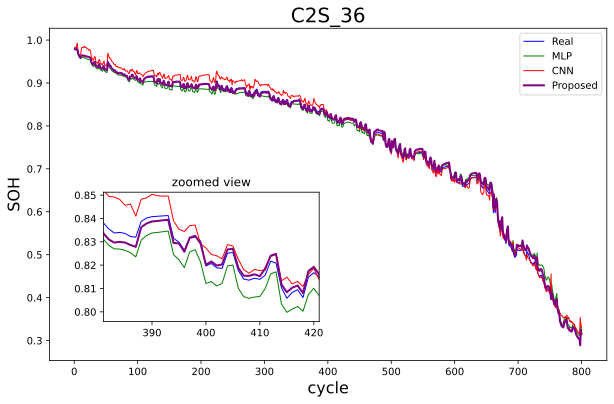

In [35]:
def plot_curves_with_zoom( y_real, y_mlp, y_cnn ,y_proposed,zoom='zoomed view',title='CS2_35 Battery'):
    # 创建主图
    plt.figure(figsize=(10, 6))

    x_real = np.arange(1, len(y_real) + 1)
    # 绘制主图中的四条曲线
    plt.plot(x_real, y_real, label='Real', color='blue', linewidth=1)
    plt.plot(x_real, y_mlp, label='MLP', color='green', linewidth=1)
    plt.plot(x_real, y_cnn, label='CNN', color='red', linewidth=1)
    # plt.plot(x_real, y_MOE, label='MOE', color='orange', linewidth=1)
    plt.plot(x_real, y_proposed, label='Proposed', color='purple', linewidth=2)
    
    # 设置主图标题和标签
    plt.title(title,fontsize=20)
    plt.xlabel('cycle',fontsize=16)
    plt.ylabel('SOH',fontsize=16)
    plt.legend(loc='upper right')  # 图例在右上角
    
    # 添加放大图
    ax_inset = plt.axes([0.2, 0.2, 0.3, 0.3])  # 放大图的位置和大小
    ax_inset.plot(x_real, y_real, color='blue', linewidth=1)
    ax_inset.plot(x_real, y_mlp, color='green', linewidth=1)
    ax_inset.plot(x_real, y_cnn, color='red', linewidth=1)
    # ax_inset.plot(x_real, y_MOE, color='orange', linewidth=1)
    ax_inset.plot(x_real, y_proposed, color='purple', linewidth=2)
    
    # 设置放大图的显示范围（取中间一小段）
    mid_point = len(x_real) // 2
    zoom_range = 20  # 放大范围
    ax_inset.set_xlim(x_real[mid_point - zoom_range], x_real[mid_point + zoom_range])
    ax_inset.set_ylim(min(y_real[mid_point - zoom_range:mid_point + zoom_range]) - 0.01,
                      max(y_real[mid_point - zoom_range:mid_point + zoom_range]) + 0.01)
    
    # 设置放大图标题
    ax_inset.set_title(zoom)
    plt.grid(False)
    # 显示图像
    plt.show()

# 示例数据
x = np.linspace(0, 10, 500)
y_real = np.sin(x)
y_mlp = np.sin(x) + 0.1 * np.random.normal(size=len(x))
y_cnn = np.sin(x) + 0.05 * np.random.normal(size=len(x))
y_proposed = np.sin(x) + 0.02 * np.random.normal(size=len(x))

# 调用函数
plot_curves_with_zoom(test_results[0][0][:800],test_results_mlp[0][1][:800], test_results_conv[0][1][:800],test_results[0][1][:800],title='C2S_36')

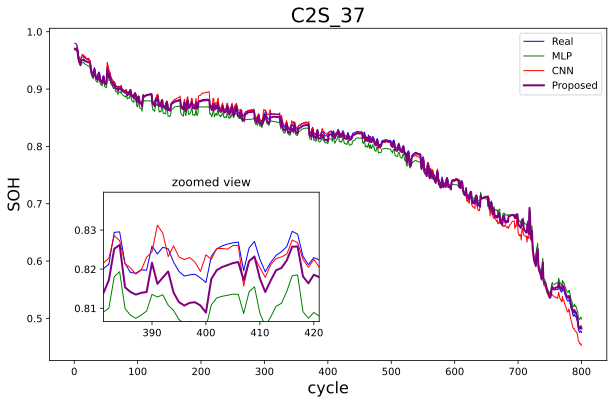

In [36]:
# """CS2_37"""
plot_curves_with_zoom(test_results[1][0][:800],test_results_mlp[1][1][:800], test_results_conv[1][1][:800],test_results[1][1][:800],title='C2S_37')

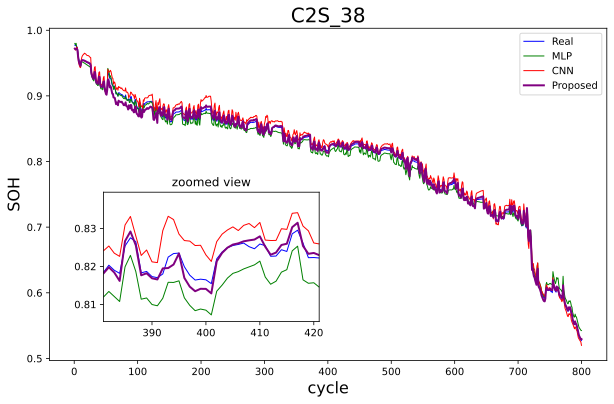

In [37]:
plot_curves_with_zoom(test_results[2][0][:800],test_results_mlp[2][1][:800], test_results_conv[2][1][:800],test_results[2][1][:800],title='C2S_38')

[ 0.          0.02003874  0.04006943  0.06008403  0.0800745   0.10003281
  0.11995096  0.13982093  0.15963474  0.17938446  0.19906213  0.21865986
  0.23816978  0.25758405  0.27689487  0.2960945   0.31517522  0.33412937
  0.35294934  0.37162756  0.39015654  0.40852884  0.42673708  0.44477394
  0.46263218  0.48030464  0.49778421  0.51506387  0.53213669  0.54899581
  0.56563445  0.58204594  0.59822369  0.61416119  0.62985206  0.64528998
  0.66046875  0.67538229  0.6900246   0.70438981  0.71847213  0.73226593
  0.74576565  0.75896588  0.77186131  0.78444678  0.79671721  0.80866769
  0.82029342  0.83158972  0.84255206  0.85317605  0.8634574   0.873392
  0.88297585  0.89220511  0.90107606  0.90958515  0.91772896  0.92550421
  0.93290779  0.93993672  0.94658819  0.95285951  0.95874817  0.96425181
  0.96936821  0.97409532  0.97843124  0.98237423  0.98592271  0.98907525
  0.99183059  0.99418762  0.99614539  0.99770312  0.99886017  0.9996161
  0.99997059  0.99992349  0.99947484  0.99862481  0.99

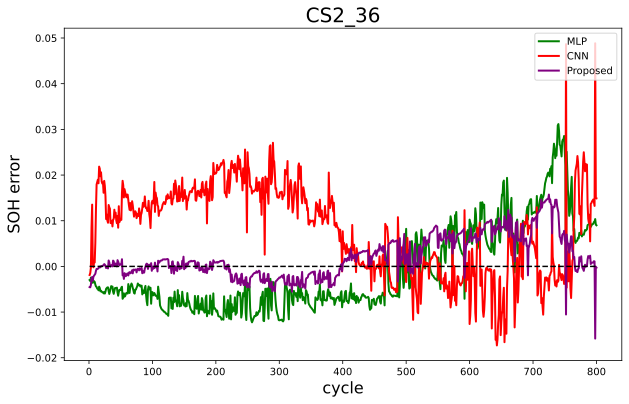

In [40]:
def subtract_lists(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("两个列表的长度必须相同！")
    return [x - y for x, y in zip(list1, list2)]
def plot_difference_curves(y_real, y_mlp, y_cnn, y_proposed,title='C2S'):
    # 生成 x 值（从 1 开始递增）
    # 创建主图
    plt.figure(figsize=(10, 6))

    x_real = np.arange(1, len(y_real) + 1)
    # 绘制主图中的四条曲线
    plt.plot(x_real, y_mlp-y_real, label='MLP', color='green', linewidth=2)
    plt.plot(x_real, y_cnn-y_real, label='CNN', color='red', linewidth=2)
    # plt.plot(x_real, y_moe-y_real, label='MOE', color='orange', linewidth=1)
    plt.plot(x_real, y_proposed-y_real, label='Proposed', color='purple', linewidth=2)
    plt.plot(x_real,0*y_mlp,color='black',linestyle='--')
    # 设置主图标题和标签
    plt.title(title,fontsize=20)
    plt.xlabel('cycle',fontsize=16)
    plt.ylabel('SOH error',fontsize=16)
    plt.legend(loc='upper right')  # 图例在右上角
    plt.show()
# # 示例数据
# y_real = np.sin(np.linspace(0, 10, 100))  # 真实曲线
# y_mlp = y_real + 0.1 * np.random.normal(size=len(y_real))  # MLP 曲线
# y_cnn = y_real + 0.05 * np.random.normal(size=len(y_real))  # CNN 曲线
# y_moe = y_real + 0.02 * np.random.normal(size=len(y_real))  # MOE 曲线
# y_proposed = y_real + 0.01 * np.random.normal(size=len(y_real))  # Proposed 曲线
print(y_real)
print((test_results[2][1][:800].shape))

# 调用函数
plot_difference_curves(test_results[0][0][:800],test_results_mlp[0][1][:800].reshape(-1), 
                       test_results_conv[0][1][:800].reshape(-1),
                       test_results[0][1][:800].reshape(-1),title='CS2_36')